<a href="https://colab.research.google.com/github/joefreire/python-testes/blob/master/Previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files, drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.tseries.offsets import DateOffset
%matplotlib inline
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

### Teste da amostra
from statsmodels.tsa.stattools import adfuller

#Ho: amostra não estacionaria
#H1: amostra estacionaria

def adfuller_test(amostra):
    result=adfuller(amostra)
    labels = ['ADF Test Statistic','p-value','#Lags Used','observações']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários")
    else:
        print("evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária ")


 
df = pd.read_csv('/content/drive/MyDrive/previsao/dataset2.csv')
df["Escopo1"]=df["Escopo1"].str.replace(",",".").astype(float)
df["Escopo2"]=df["Escopo2"].str.replace(",",".").astype(float)
df["Escopo3"]=df["Escopo3"].str.replace(",",".").astype(float)
df['Ref']=pd.to_datetime(df['Ref'])
df.set_index('Ref',inplace=True)

escopo1 = df.filter(['Ref','Escopo1'], axis=1)


escopo1.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Escopo1
Ref,
2016-01-01,56.077615
2016-02-01,44.377551
2016-03-01,30.970758
2016-04-01,13.966298
2016-05-01,4.044635


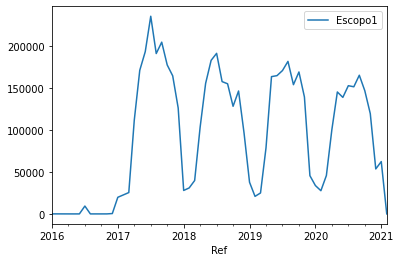

In [5]:
escopo1.plot()

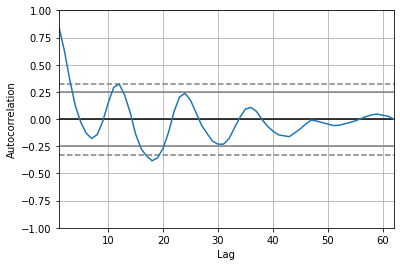

In [ ]:
autocorrelation_plot(escopo1)
pyplot.show()

In [6]:
adfuller_test(escopo1['Escopo1'])

ADF Test Statistic : -2.377818956596378
p-value : 0.14809495276588175
#Lags Used : 8
observações : 53
evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária 


In [10]:
escopo1['Primeira Diferenciação'] = escopo1['Escopo1'] - escopo1['Escopo1'].shift(1)
escopo1['Escopo1'].shift(1)

Ref
2016-01-01              NaN
2016-02-01        56.077615
2016-03-01        44.377551
2016-04-01        30.970758
2016-05-01        13.966298
                  ...      
2020-10-01    165293.292300
2020-11-01    146859.805800
2020-12-01    119523.288100
2021-01-01     53610.126250
2021-02-01     62396.954630
Name: Escopo1, Length: 62, dtype: float64

In [9]:
escopo1['Diferença Sazonal']=escopo1['Escopo1']-escopo1['Escopo1'].shift(12)
escopo1.head(14)

,Escopo1,Primeira Diferenciação,Diferença Sazonal
Ref,,,
2016-01-01,56.077615,NaN,NaN
2016-02-01,44.377551,-11.700064,NaN
2016-03-01,30.970758,-13.406793,NaN
2016-04-01,13.966298,-17.004460,NaN
2016-05-01,4.044635,-9.921663,NaN
2016-06-01,20.078825,16.034190,NaN
2016-07-01,9368.828837,9348.750012,NaN
2016-08-01,16.267830,-9352.561007,NaN
2016-09-01,17.860978,1.593148,NaN


In [11]:
## dickey fuller test
adfuller_test(escopo1['Diferença Sazonal'].dropna())

ADF Test Statistic : -8.135187845574203
p-value : 1.063901248181605e-12
#Lags Used : 11
observações : 38
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


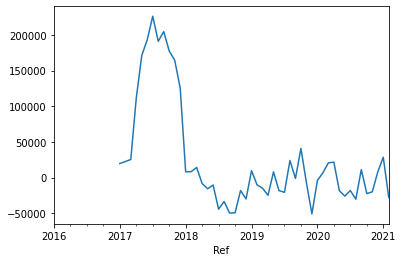

In [12]:
escopo1['Diferença Sazonal'].plot()

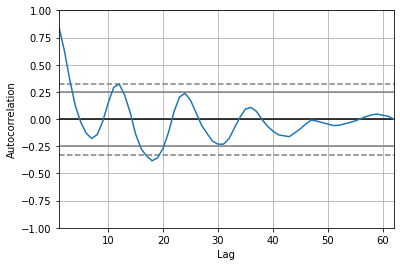

In [13]:
autocorrelation_plot(escopo1['Escopo1'])
plt.show()

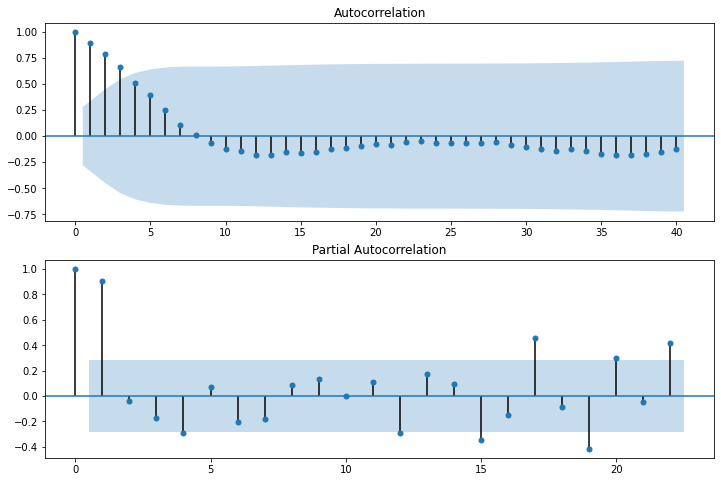

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo1['Diferença Sazonal'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo1['Diferença Sazonal'].iloc[13:],lags=22,ax=ax2)

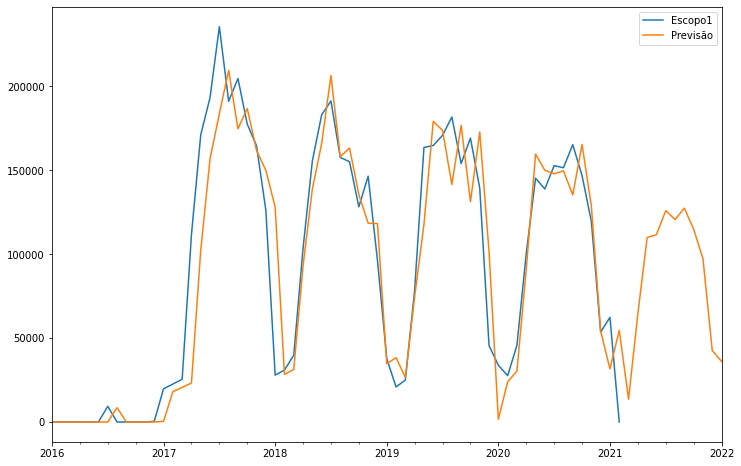

In [15]:

model=sm.tsa.statespace.SARIMAX(escopo1['Escopo1'],order=(1,0,0),seasonal_order=(1,1,1,12))
results=model.fit()
future_dates=[escopo1.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=escopo1.columns)
future_df=pd.concat([escopo1,future_datest_df])

future_df['Previsão'] = results.predict(end = 72)  

future_df[['Escopo1', 'Previsão']].plot(figsize=(12, 8))


In [16]:
print(future_df)

              Escopo1  Primeira Diferenciação  Diferença Sazonal       Previsão
2016-01-01  56.077615                     NaN                NaN       0.000000
2016-02-01  44.377551              -11.700064                NaN      50.073922
2016-03-01  30.970758              -13.406793                NaN      39.197493
2016-04-01  13.966298              -17.004460                NaN      26.746570
2016-05-01   4.044635               -9.921663                NaN      11.008816
...               ...                     ...                ...            ...
2021-09-01        NaN                     NaN                NaN  127462.111981
2021-10-01        NaN                     NaN                NaN  114944.260051
2021-11-01        NaN                     NaN                NaN   97359.028418
2021-12-01        NaN                     NaN                NaN   42684.129654
2022-01-01        NaN                     NaN                NaN   36119.657749

[73 rows x 4 columns]


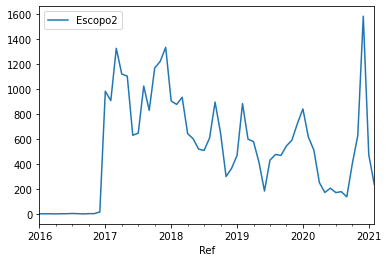

In [17]:
#dados escopo2
escopo2 = df.filter(['Ref','Escopo2'], axis=1)

#tratamento dos dados vazios, quando 0 eu busco ou a media do mês ou a media do ano

for index, row in escopo2.iterrows():
    if row['Escopo2'] <= 0:
      mediaMes = escopo2['Escopo2'].groupby([escopo2.index.month]).mean()[index.month]
      mediasAno = escopo2['Escopo2'].groupby([escopo2.index.year]).mean()
      mediaAno = escopo2['Escopo2'].groupby([escopo2.index.year]).mean()[index.year]

      if mediaMes == 0.0:         
         row['Escopo2'] = mediaAno
      elif mediaAno == 0.0:  
         if (index.year-1 in mediasAno) and ((mediaMes * 1.2 < mediasAno[index.year-1]) or (mediaMes * 1.2 > mediasAno[index.year-1])):
          row['Escopo2'] = mediasAno[index.year-1]
         else:
          row['Escopo2'] = mediaMes
      elif (mediaAno < (mediaMes * 1.2)):
         row['Escopo2'] = mediaAno
      else:
         row['Escopo2'] = mediaMes        
escopo2.plot()


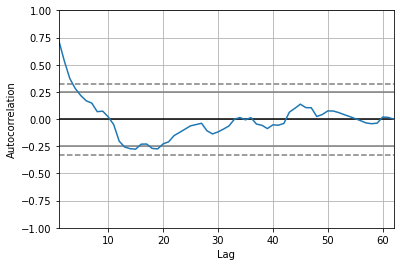

In [18]:
autocorrelation_plot(escopo2)
pyplot.show()


In [19]:
adfuller_test(escopo2['Escopo2'])

ADF Test Statistic : -3.1150144121051886
p-value : 0.025461824303790195
#Lags Used : 0
observações : 61
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


In [20]:
escopo2['Primeira Diferenciação'] = escopo2['Escopo2'] - escopo2['Escopo2'].shift(1)
escopo2['Diferença Sazonal']=escopo2['Escopo2']-escopo2['Escopo2'].shift(12)
print(escopo2)

                Escopo2  Primeira Diferenciação  Diferença Sazonal
Ref                                                               
2016-01-01     1.945514                     NaN                NaN
2016-02-01     2.107640                0.162126                NaN
2016-03-01     2.283277                0.175637                NaN
2016-04-01     1.226124               -1.057153                NaN
2016-05-01     2.473550                1.247426                NaN
...                 ...                     ...                ...
2020-10-01   401.533155              263.824481        -142.543925
2020-11-01   627.318220              225.785065          36.276455
2020-12-01  1581.009679              953.691459         857.258106
2021-01-01   474.592304            -1106.417375        -365.094113
2021-02-01   237.296152             -237.296152        -378.238534

[62 rows x 3 columns]


In [21]:
## dickey fuller test
adfuller_test(escopo2['Diferença Sazonal'].dropna())


ADF Test Statistic : -6.090660237157593
p-value : 1.0384075926380125e-07
#Lags Used : 11
observações : 38
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


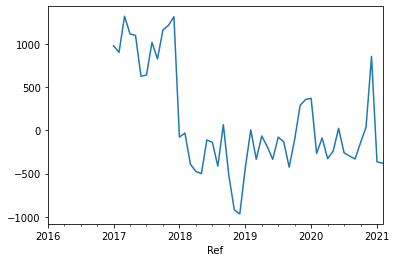

In [22]:
escopo2['Diferença Sazonal'].plot()

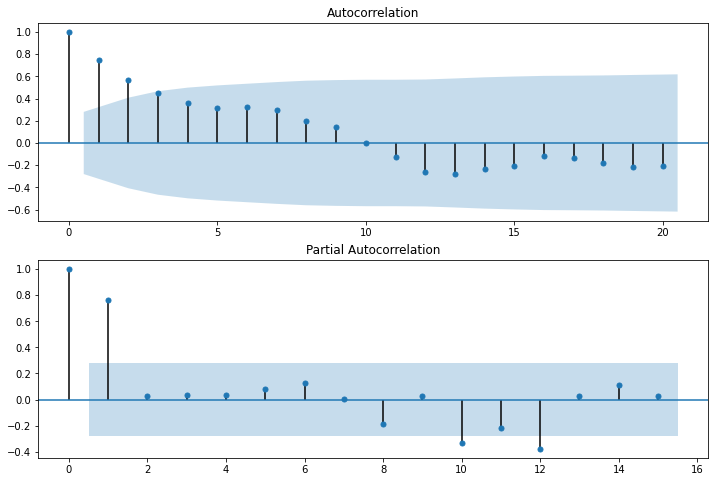

In [23]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo2['Diferença Sazonal'].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo2['Diferença Sazonal'].iloc[13:],lags=15,ax=ax2)

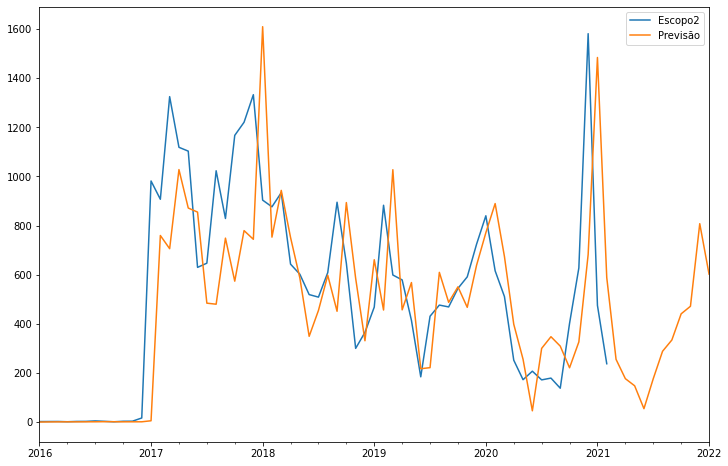

In [24]:
#essa é o modelo que foi aprendido para as previsões
model2=sm.tsa.statespace.SARIMAX(escopo2['Escopo2'],order=(1,0,0),seasonal_order=(1,1,1,12))
results2=model2.fit()

future_dates2=[escopo2.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest2_df=pd.DataFrame(index=future_dates2[1:],columns=escopo2.columns)
future_df2=pd.concat([escopo2,future_datest2_df])


future_df2['Previsão'] = results2.predict(end=72)  

#future_df2['Previsão'] = future_df2['Previsão'].apply(lambda x : x if x > 0 else 0)

future_df2[['Escopo2', 'Previsão']].plot(figsize=(12, 8))


In [28]:
future_df2.tail(24)

,Escopo2,Primeira Diferenciação,Diferença Sazonal,Previsão
2020-02-01,615.534686,-224.151731,-266.974245,889.401564
2020-03-01,510.685424,-104.849262,-87.846227,673.623674
2020-04-01,251.781401,-258.904023,-326.845387,398.090375
2020-05-01,172.380544,-79.400857,-241.246000,255.644429
2020-06-01,206.997883,34.617339,22.946508,45.716800
2020-07-01,171.578371,-35.419512,-259.111499,299.873337
2020-08-01,178.893198,7.314827,-297.263525,347.339668
2020-09-01,137.708674,-41.184524,-330.873447,309.019927
2020-10-01,401.533155,263.824481,-142.543925,220.850729
2020-11-01,627.318220,225.785065,36.276455,326.137663


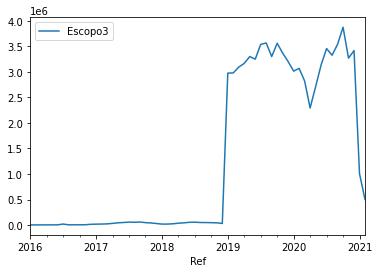

In [29]:

#dados escopo3
escopo3 = df.filter(['Ref','Escopo3'], axis=1)

#tratamento dos dados vazios, quando 0 eu busco ou a media do mês ou a media do ano
for index, row in escopo3.iterrows():
    if row['Escopo3'] <= 0:
      mediaMes = escopo3['Escopo3'].groupby([escopo3.index.month]).mean()[index.month]
      mediaAno = escopo3['Escopo3'].groupby([escopo3.index.year]).mean()[index.year]
      if mediaMes == 0.0:         
         row['Escopo3'] = mediaAno
      elif mediaAno == 0.0:  
         row['Escopo3'] = mediaMes
      elif (mediaAno < (mediaMes * 1.2)):
         row['Escopo3'] = mediaAno
      else:
         row['Escopo3'] = mediaMes
escopo3.plot()

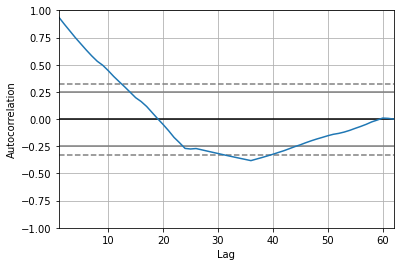

In [30]:
autocorrelation_plot(escopo3)
pyplot.show()

In [31]:
adfuller_test(escopo3['Escopo3'])

ADF Test Statistic : -1.3795389027987894
p-value : 0.5920451721826077
#Lags Used : 0
observações : 61
evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária 


In [33]:
escopo3['Primeira Diferenciação'] = escopo3['Escopo3'] - escopo3['Escopo3'].shift(1)
escopo3['Diferença Sazonal']=escopo3['Escopo3']-escopo3['Escopo3'].shift(12)
adfuller_test(escopo3['Diferença Sazonal'].dropna())

ADF Test Statistic : -1.0124661793948972
p-value : 0.7486904371565832
#Lags Used : 0
observações : 49
evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária 


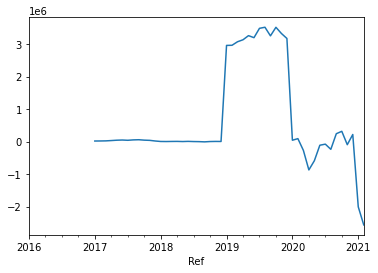

In [34]:
escopo3['Diferença Sazonal'].plot()

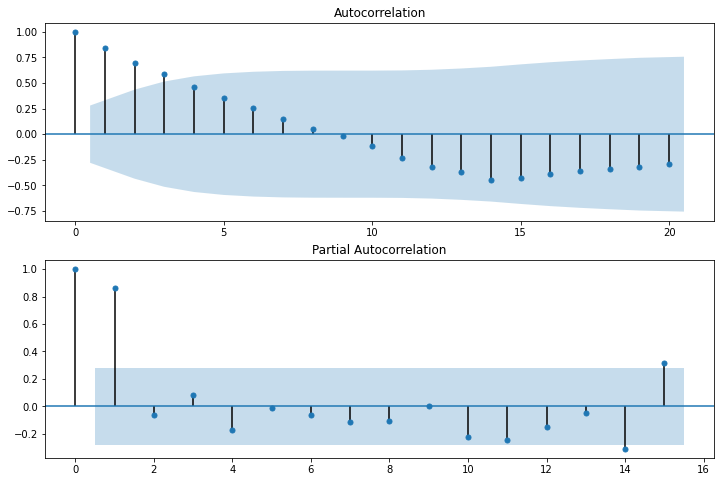

In [35]:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo3['Diferença Sazonal'].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo3['Diferença Sazonal'].iloc[13:],lags=15,ax=ax2)

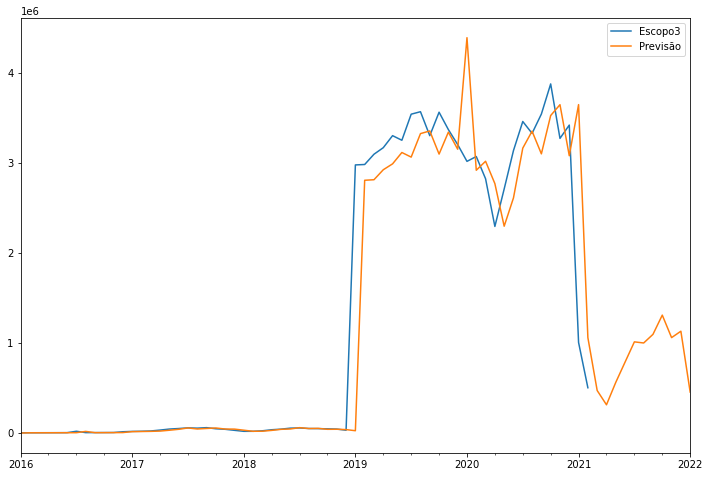

In [36]:
#essa é o modelo que foi aprendido para as previsões
model3=sm.tsa.statespace.SARIMAX(escopo3['Escopo3'],order=(1,0,0),seasonal_order=(1,1,1,12))
results3=model3.fit()

future_dates3=[escopo3.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest3_df=pd.DataFrame(index=future_dates3[1:],columns=escopo3.columns)
future_df3=pd.concat([escopo3,future_datest3_df])


future_df3['Previsão'] = results3.predict(end=72)  

future_df3[['Escopo3', 'Previsão']].plot(figsize=(12, 8))

In [37]:
future_df3.head(24)

,Escopo3,Primeira Diferenciação,Diferença Sazonal,Previsão
2016-01-01,2827.215918,NaN,NaN,0.000000
2016-02-01,3062.817245,235.601327,NaN,2555.148511
2016-03-01,3318.052015,255.234770,NaN,2765.951648
2016-04-01,3594.556350,276.504335,NaN,2993.417778
2016-05-01,3894.102712,299.546362,NaN,3238.685144
2016-06-01,4218.611272,324.508559,NaN,3502.915393
2016-07-01,19681.060180,15462.448908,NaN,3787.272388
2016-08-01,4570.162211,-15110.897969,NaN,18100.873951
2016-09-01,4951.009062,380.846851,NaN,4068.856866
2016-10-01,5363.593150,412.584088,NaN,4392.009720


In [38]:
future_df3.tail(24)

,Escopo3,Primeira Diferenciação,Diferença Sazonal,Previsão
2020-02-01,3.068874e+06,5.370648e+04,8.850191e+04,2.916682e+06
2020-03-01,2.821930e+06,-2.469439e+05,-2.724178e+05,3.016312e+06
2020-04-01,2.292864e+06,-5.290663e+05,-8.740975e+05,2.768258e+06
2020-05-01,2.708953e+06,4.160887e+05,-5.914589e+05,2.295544e+06
2020-06-01,3.135337e+06,4.263839e+05,-1.141550e+05,2.609591e+06
2020-07-01,3.457533e+06,3.221962e+05,-8.127446e+04,3.162129e+06
2020-08-01,3.325764e+06,-1.317692e+05,-2.404136e+05,3.350015e+06
2020-09-01,3.540271e+06,2.145074e+05,2.399228e+05,3.098543e+06
2020-10-01,3.874630e+06,3.343591e+05,3.138942e+05,3.524000e+06
2020-11-01,3.270238e+06,-6.043926e+05,-9.757008e+04,3.644142e+06
